In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from firstTry import FaceData
import time
import os

from classifiers.segmentation_bis import SegmentationNN

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.ion()   # interactive mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
train_data = FaceData(image_paths_file='LAG/train/train.txt')
val_data = FaceData(image_paths_file='LAG/val/val.txt')
print(train_data[0][1].size)
print(train_data[0][0].size())


   11    14    17  ...     21    12     6
    7    11    16  ...     16     9     5
    4     6    10  ...     12     6     4
       ...          ⋱          ...       
   94    93    95  ...     71    61    55
   95    93    96  ...     49    51    60
   95    94    96  ...     61    60    66
[torch.FloatTensor of size 200x200]

<built-in method size of torch.FloatTensor object at 0x7f27b7441a48>

   11    14    17  ...     21    12     6
    7    11    16  ...     16     9     5
    4     6    10  ...     12     6     4
       ...          ⋱          ...       
   94    93    95  ...     71    61    55
   95    93    96  ...     49    51    60
   95    94    96  ...     61    60    66
[torch.FloatTensor of size 200x200]

torch.Size([3, 200, 200])


Train size: 847
Validation size: 164

   11    14    17  ...     21    12     6
    7    11    16  ...     16     9     5
    4     6    10  ...     12     6     4
       ...          ⋱          ...       
   94    93    95  ...     71    61    55
   95    93    96  ...     49    51    60
   95    94    96  ...     61    60    66
[torch.FloatTensor of size 200x200]

Img size:  torch.Size([3, 200, 200])

   11    14    17  ...     21    12     6
    7    11    16  ...     16     9     5
    4     6    10  ...     12     6     4
       ...          ⋱          ...       
   94    93    95  ...     71    61    55
   95    93    96  ...     49    51    60
   95    94    96  ...     61    60    66
[torch.FloatTensor of size 200x200]

Segmentation size:  torch.Size([200, 200])

   11    14    17  ...     21    12     6
    7    11    16  ...     16     9     5
    4     6    10  ...     12     6     4
       ...          ⋱          ...       
   94    93    95  ...     71    61    55
   95   

ValueError: cannot reshape array of size 120000 into shape (200,200)

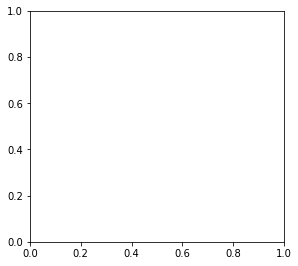

In [43]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 9
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().reshape(200,200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(target.numpy().reshape(200,200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'LAG'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()


/home/carlodedonno/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [3]:
from classifiers.segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F
import torchvision.models as models

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=4)
model = SegmentationNN()
for param in list(model.parameters())[:-2]:
    param.requires_grad = False
    

solver = Solver(optim_args={"lr": 1e-4,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.CrossEntropyLoss(ignore_index = -1))

solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=80)

START TRAIN.

  254   254   254  ...    254   254   254
  254   254   254  ...    254   254   254
  254   254   254  ...    254   254   254
       ...          ⋱          ...       
    8     7     7  ...     20    19    21
    8     7     7  ...     20    19    21
    7     6     6  ...     20    19    21
[torch.FloatTensor of size 200x200]


  129   131   134  ...     73    85   100
  131   131   131  ...     81    66    75
  135   134   126  ...     72    65    72
       ...          ⋱          ...       
  148   155   172  ...     10    12    13
  128   136   166  ...     10    11    14
  152   156   177  ...     10    10    12
[torch.FloatTensor of size 200x200]


  211   199   201  ...      1     1     0
  205   215   193  ...      1     1     0
  216   187   210  ...      1     1     0
       ...          ⋱          ...       
    1     0     1  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 2



  181   181   180  ...    181   188   190
  182   182   182  ...    179   188   190
  183   183   183  ...    177   187   191
       ...          ⋱          ...       
  208   206   204  ...     40    41    41
  207   205   203  ...     40    42    43
  206   205   203  ...     43    45    45
[torch.FloatTensor of size 200x200]


  129   128   126  ...    184   185   185
  128   127   126  ...    184   185   185
  128   127   126  ...    184   185   185
       ...          ⋱          ...       
   52    48    47  ...     83    82    81
   45    46    45  ...     84    84    83
   46    43    41  ...     80    81    84
[torch.FloatTensor of size 200x200]


  239   240   241  ...    236   231   230
  238   240   241  ...    229   230   234
  238   239   240  ...    223   230   236
       ...          ⋱          ...       
  175   176   171  ...    107   107   108
  166   159   156  ...    105   103   105
  166   155   137  ...    103   102   105
[torch.FloatTensor of size 200x200]


  



   79    83    89  ...    215   220   201
   84    89    95  ...    223   206   161
   92    97    99  ...    226   182   123
       ...          ⋱          ...       
   46    59    75  ...      6     4     4
   24    29    46  ...      6     5     4
   51    42    47  ...      6     6     2
[torch.FloatTensor of size 200x200]

[Iteration 4/16960] TRAIN loss: 5.636

  245   246   246  ...      0     0     0
  245   246   246  ...      0     0     0
  246   246   246  ...      0     0     0
       ...          ⋱          ...       
    3     3     3  ...      0     0     0
    1     2     1  ...      0     0     0
  138   166     3  ...      0     0     0
[torch.FloatTensor of size 200x200]


  230   230   230  ...      3     1     0
  230   230   230  ...      3     1     0
  231   231   231  ...      3     1     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[t



  246   245   245  ...    248   249   249
  246   246   245  ...    248   248   249
  246   246   245  ...    248   248   249
       ...          ⋱          ...       
  244   244   244  ...    166   173   178
  245   245   245  ...    165   171   176
  246   246   245  ...    171   177   173
[torch.FloatTensor of size 200x200]

[Iteration 10/16960] TRAIN loss: 5.634

  180   184   190  ...    185   182   176
  178   183   189  ...    187   182   176
  176   181   188  ...    187   181   174
       ...          ⋱          ...       
   15    15    15  ...    187   203   187
   16    15    15  ...    157   172   154
   16    15    15  ...     96   108   100
[torch.FloatTensor of size 200x200]


  254   254   254  ...    250   246   223
  253   254   254  ...    251   246   223
  251   254   253  ...    252   246   226
       ...          ⋱          ...       
  234   232   228  ...    241   220   195
  234   233   231  ...    243   227   205
  233   232   232  ...    246   229   211
[



   48    54    66  ...     88    82    88
   51    53    62  ...     83    88    96
   57    55    62  ...     87    86    98
       ...          ⋱          ...       
   45    47    42  ...     52    45    42
   43    49    43  ...     51    44    45
   48    45    46  ...     45    45    51
[torch.FloatTensor of size 200x200]

[Iteration 16/16960] TRAIN loss: 5.642

  181   179   164  ...    245   245   246
  181   176   165  ...    245   245   246
  186   171   178  ...    247   246   245
       ...          ⋱          ...       
   39    42    45  ...     16    16    19
   93    98   100  ...     20    18    21
  115   115   115  ...     19    18    16
[torch.FloatTensor of size 200x200]


  222   221   228  ...      0     0     0
  223   223   204  ...      0     0     0
  216   202   198  ...      0     0     0
       ...          ⋱          ...       
   19    17    16  ...     31    30    30
   19    17    16  ...     37    36    36
   19    18    17  ...     22    24    28
[



  239   239   239  ...    243   243   243
  239   239   239  ...    243   243   243
  239   239   239  ...    243   243   243
       ...          ⋱          ...       
    7     8     7  ...      3     7    11
    6     7     7  ...      3     8    13
    3     7     8  ...      2     8    14
[torch.FloatTensor of size 200x200]

[Iteration 22/16960] TRAIN loss: 5.630

  251   247   246  ...    249   246   240
  253   251   247  ...    248   244   237
  254   254   251  ...    244   244   240
       ...          ⋱          ...       
   24    25    24  ...     29    31    29
   26    28    25  ...     31    29    30
   25    26    24  ...     27    27    28
[torch.FloatTensor of size 200x200]


   33    26    24  ...    236   236   236
   35    32    21  ...    236   236   236
   33    30    24  ...    237   236   236
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[



    1     0     0  ...    216     0     0
    1     0     0  ...     44     0     0
    1     0     0  ...    158     0     0
       ...          ⋱          ...       
    1     0     0  ...    161     0     0
    1     0     0  ...    165     0     0
    1     0     0  ...     25     0     0
[torch.FloatTensor of size 200x200]

[Iteration 28/16960] TRAIN loss: 5.640

  223   222   222  ...    235   235   234
  222   223   223  ...    235   235   234
  222   223   226  ...    235   235   234
       ...          ⋱          ...       
  222   222   221  ...    184   186   120
  220   219   219  ...    183   184   126
  220   220   218  ...    186   180   130
[torch.FloatTensor of size 200x200]


   88    84    72  ...     46    46    47
   79    78    73  ...     43    43    45
   78    75    77  ...     38    40    41
       ...          ⋱          ...       
   20    19    16  ...      0     0     0
   18    16    15  ...      0     0     0
   17    15    15  ...      0     0     0
[



  149   240   234  ...    213   213   213
  145   242   236  ...    213   213   213
  152   241   239  ...    213   213   213
       ...          ⋱          ...       
  240   237   237  ...    219   219   220
  240   236   237  ...    218   218   220
  240   235   237  ...    218   218   221
[torch.FloatTensor of size 200x200]


  119   124   126  ...     62    64    68
  118   117   123  ...     61    60    65
  113   122   122  ...     61    63    64
       ...          ⋱          ...       
   20    20    20  ...     13    12    11
   19    19    19  ...     12    13    11
   18    19    19  ...     12    13    11
[torch.FloatTensor of size 200x200]

[Iteration 34/16960] TRAIN loss: 5.657

  229   228   228  ...    215   214   214
  229   229   229  ...    215   214   214
  229   229   229  ...    215   215   214
       ...          ⋱          ...       
   43    43    42  ...     37    46    47
   41    40    39  ...     35    41    47
   39    39    39  ...     35    39    46
[



  209   208   211  ...    209   209   209
  210   210   210  ...    209   209   209
  206   205   204  ...    209   209   209
       ...          ⋱          ...       
  231   233   232  ...    227   226   224
  232   234   234  ...    229   228   225
  233   233   231  ...    230   229   227
[torch.FloatTensor of size 200x200]


  106   102    99  ...    205   202   205
  106   103    99  ...    204   202   206
  106   103   100  ...    203   202   206
       ...          ⋱          ...       
   57    55    54  ...    183   185   186
   53    53    52  ...    184   186   187
   56    56    56  ...    183   185   186
[torch.FloatTensor of size 200x200]
[Iteration 40/16960] TRAIN loss: 5.625


  246   248   251  ...     51    51    51
  246   248   251  ...     51    51    51
  246   248   251  ...     51    51    51
       ...          ⋱          ...       
  110    78    83  ...     12    12    10
  115    81    83  ...     11    12    10
  114    78    82  ...     10    11    10
[


[Iteration 46/16960] TRAIN loss: 5.640

  161   159   149  ...     69    69    69
  162   160   150  ...     67    67    67
  161   158   150  ...     63    64    64
       ...          ⋱          ...       
    0     0     0  ...      1     3     4
    0     0     0  ...      1     3     4
    0     0     0  ...      1     2     4
[torch.FloatTensor of size 200x200]


    0     0     2  ...    218   210   201
    0     0     1  ...    217   209   199
    0     0     0  ...    217   209   198
       ...          ⋱          ...       
    2    92   136  ...    179   163   148
    9   103   135  ...    179   163   148
   21   106   133  ...    179   162   148
[torch.FloatTensor of size 200x200]


  114    87    70  ...    113   112   111
  105    70    75  ...    112   111   110
   98   103    84  ...    112   111   110
       ...          ⋱          ...       
   71   124   119  ...      0     0     0
   93    56    64  ...      0     0     0
    7    53    56  ...      0     0     0
[



   13    11    15  ...     22    23    24
   15    14    14  ...     19    22    25
   18    15    12  ...     11    14    18
       ...          ⋱          ...       
   51    45    42  ...     18    22    25
   40    37    40  ...     25    27    29
   46    50    51  ...     25    26    25
[torch.FloatTensor of size 200x200]

[Iteration 52/16960] TRAIN loss: 5.642

   73    72    70  ...    233   233   233
   73    73    71  ...    233   233   233
   75    74    72  ...    233   233   233
       ...          ⋱          ...       
  172   166   160  ...     46    42    40
  177   169   162  ...     45    42    43
  181   174   165  ...     41    39    42
[torch.FloatTensor of size 200x200]


  169   166   165  ...     58    64    67
  175   173   170  ...     58    62    67
  179   177   172  ...     58    60    66
       ...          ⋱          ...       
  181   181   176  ...    254   252   241
  179   174   173  ...    254   253   254
  174   172   171  ...    249   253   254
[



   65    53    61  ...     14   113     0
   65    57    57  ...     14   111     0
   50    61    62  ...     14   109     0
       ...          ⋱          ...       
    8     9    10  ...     73    83    82
    9    10    11  ...     61    63    62
   10    10    12  ...     59    55    49
[torch.FloatTensor of size 200x200]
[Iteration 58/16960] TRAIN loss: 5.642


   76    63    62  ...      0     0     0
   71    61    67  ...      0     0     0
   72    78    84  ...      0     0     0
       ...          ⋱          ...       
  137   136   135  ...    106    97    87
  137   137   134  ...    106    96    86
  139   139   136  ...    105    95    93
[torch.FloatTensor of size 200x200]


  235   235   235  ...    183   166   150
  235   235   235  ...    183   165   151
  235   235   235  ...    183   164   151
       ...          ⋱          ...       
   48    46    44  ...    160   147     5
   44    44    44  ...    160   146     4
   45    44    43  ...    160   147     4
[



  239   238   238  ...    235   235   235
  239   238   238  ...    235   235   235
  239   238   238  ...    235   235   235
       ...          ⋱          ...       
   56    60    56  ...    127   134   143
   50    52    51  ...    112   117   122
   47    47    49  ...    101   107   113
[torch.FloatTensor of size 200x200]


   41    39    36  ...    170   177   180
   43    40    37  ...    168   179   182
   45    43    40  ...    168   179   186
       ...          ⋱          ...       
   21    17    20  ...    124   119   111
   25    25    28  ...    123   115   109
   25    31    39  ...    121   113   110
[torch.FloatTensor of size 200x200]

[Iteration 64/16960] TRAIN loss: 5.635

  188   186   181  ...    234   239   239
  189   188   182  ...    233   237   238
  190   189   183  ...    231   236   237
       ...          ⋱          ...       
   18    19    19  ...     25    24    26
   19    19    19  ...     25    26    27
   19    19    18  ...     25    26    27
[

Process Process-4:
Process Process-3:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/carlodedonno/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/carlodedonno/anaconda3/lib/python3.

KeyboardInterrupt: 